## Auto reload

In [76]:
%reload_ext autoreload
%autoreload 2

## Imports

In [77]:

import math

import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
from collections import namedtuple,defaultdict,OrderedDict
import itertools

import torch
from torch.nn import Transformer
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import skimage.color as color
import numpy as np
import random

import utils
from utils import END_SYMBOL, START_SYMBOL, UNK_SYMBOL, PAD_SYMBOL

import color_processing as cp
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ColorEmbedding
A class to overlay a color embedding on top of embedding corresponding to the token + position

In [78]:
class ColorEmbeddings(torch.nn.Module):
    def __init__(self, d_model: int, c_embed: OrderedDict):
        super().__init__()
        self.d_model = d_model
        self.pretrained_embedding = self.create_pretrained_embeddings(c_embed)
        self.max_length = len(c_embed)
        # print(f"pretrained_embeddings:{self.pretrained_embedding.weight.shape}")

    def from_existing(self, src:Tensor, src_c:Tensor):
        src   = src.clone().squeeze().detach().numpy().tolist()
        src_c = src_c.clone().squeeze().detach().numpy().tolist()

        sc_max = self.max_length - 1

        map = { s: min(sc,sc_max) for s,sc in zip(src,src_c)}

        myKeys = list(map.keys())
        myKeys.sort()
        map = {i: map[i] for i in myKeys}

        batch = torch.from_numpy( np.array(list(map.values())) )
        batch = self.forward(batch)

        return map, torch.nn.Embedding.from_pretrained(batch,freeze=True)

    def create_pretrained_embeddings(self,c_embed) :
        pe = np.zeros(  (len(c_embed), self.d_model))
        x  = np.array([ c_embed[i] for i in range(len(c_embed)) ])
        pe[:,0:c_embed[0].shape[0]] = x
        return torch.nn.Embedding.from_pretrained(torch.from_numpy(pe).float(),freeze=True)

    def forward(self, batch):
        mask = (batch >= self.pretrained_embedding.num_embeddings)
        pretrained_batch = batch.detach().clone()
        pretrained_batch[mask] = self.pretrained_embedding.num_embeddings - 1
        embedded_batch = self.pretrained_embedding(pretrained_batch)
        return embedded_batch

## Color representation
take the hls color, convert to rgb and this gives the target to shoot for. 

In [ ]:
color_enbedding_dimension = 128

def return_color(rgb_c) :
    lab = color.rgb2lab(np.asarray(rgb_c ))
    lab[0] = lab[0] /100.0 * 2.0 - 1.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    return lab

def represent_color(rgb_c):
    lab = return_color(rgb_c)
    a    = np.pi
    size = color_enbedding_dimension - 1 
    c = [ np.dot( lab , [2.0,np.cos(a*t/size),np.sin(a*t/size)] ) for t  in range(0,size+1,1) ]
    return np.array(c)

## Toy colors to discriminate
Patches encode a name,  rgb color and index for the ColorEmbedding

ColorToyDataset creates a dataset from patches for training the transformer that has:
- every unique combination of 3 colors in the list (e.g. get_unique_permutations )
- each of the 3 colors becomes a target 
- all 6 orders of the 3 colors in the data ( e.g. shuffle_idxs )

This ensures no memorization is possible. the transformer must learn how to point. 

In [138]:
Patch    = namedtuple("Patch", "text color idx")
PatchSet = namedtuple("PatchSet", "patches idx target t")


test_patches = [
    # Patch('red',[1.0,0.0 ,0.0 ],0),
    # Patch('blue',[0.0,1.0 ,0.0 ],1),
    # Patch('green',[0.0,0.0 ,1.0 ],2),
    # Patch('colorx',[.62,0.12,0.95],3),

    Patch("red"    ,[1.0,0.0 ,0.0 ],0),
    Patch("red.9"    ,[.9,0.0 ,0.0 ],1),
    Patch("red.8"    ,[.8,0.0 ,0.0 ],2),
    Patch("red.7"    ,[.7,0.0 ,0.0 ],3),
    Patch("green"    ,[0.0,1.0 ,0.0 ],4),
    Patch("green.9"   ,[0.0,.9 ,0.0 ],5),
    Patch("green.8"  ,[0.0,.8 ,0.0 ],6),
    Patch("green.7"  ,[0.0,.7 ,0.0 ],7),
    Patch("blue"    ,[0.0,0.0 ,1.0 ],8),
    Patch("orange"   ,[1.0,0.65,0.0 ],9),
    Patch("yellow"   ,[1.0,1.0 ,0.0 ],10),
    Patch("purple"   ,[.62,0.12,0.95],11),
]
nocolors = 3
shuffle_idxs = list(itertools.permutations(list(range(nocolors)), nocolors)) 
reorder = lambda l,idx : [l[i] for i in idx]
# reorder = lambda l,idx : l #e.g. do not reorder

def get_unique_permutations(l,n=nocolors) :
    unique_perms = set()
    for perm in itertools.permutations(l,n):
        perm_set = frozenset(perm)
        if perm_set not in unique_perms:
            unique_perms.add(perm_set)
    return unique_perms

# l = get_unique_permutations([0,1,2,3])
# for i in l:
#     print(i) 

order_vocab = {
    0: '<color0>',
    1: '<color1>',
    2: '<color2>',
    3: '<discriminator>',
    4: PAD_SYMBOL,
    5: START_SYMBOL,
    6: END_SYMBOL,
    7: UNK_SYMBOL
}
order_dict = {v : k for k, v in order_vocab.items()}

PAD_IDX = order_dict[PAD_SYMBOL]   
BOS_IDX = order_dict[START_SYMBOL]   
EOS_IDX = order_dict[END_SYMBOL]  


class ColorToyDataset :

    def __init__(self, d_model, patches,batch_size=10) :

        self.bptt       = 12 
        self.patches = patches
        self.c_embed,self.embed_c,self.patch_sets   = self.create_color_embeddings(patches)
        self.word_dict, self.vocab, self.color_seq, self.color_order_seq = self.create_data()
        self.color_seq_data       =  np.concatenate( self.color_seq ) 
        self.color_order_seq_data =  np.concatenate( self.color_order_seq ) 
        self.colorizer       =  ColorEmbeddings(d_model, self.c_embed)
        self.batch_size      = batch_size

        # print(f"vocab size: {len(self.vocab)}")
        # print(f"example size: {len(self.color_seq)}")
        # print(f"data word count: {self.color_seq_data.shape}")

    def create_color_embeddings(self, patches ) :
        c_embed = OrderedDict()
        embed_c = OrderedDict()
        for patch in patches :
            c_embed[patch.idx]  = represent_color(patch.color)
            embed_c[patch.text] = c_embed[patch.idx] 

        last_index = len(c_embed) 

        c_embed[ last_index ] = np.zeros_like( c_embed[0] )
        embed_c[ UNK_SYMBOL ] = c_embed[ last_index] 

        patch_sets = get_unique_permutations(list(range(len(patches))))
        patchsets  = []
        idx = 0
        for patch_set in patch_sets :
            ps_patches  = [patches[i]     for i in patch_set] 
            ps_indices  = [patches[i].idx for i in patch_set]
            # patchset = PatchSet(ps_patches, ps_indices, ps_patches[0],0)
            # patchsets.append(patchset)
            for t in range(len(patch_set)) :
                patchset = PatchSet(ps_patches, ps_indices, ps_patches[t],t)
                patchsets.append(patchset)
        return c_embed, embed_c, patchsets


    def create_data(self) :
        c_embed = self.c_embed
        patch_sets = self.patch_sets

        text_list  = [ patch_set.target.text for patch_set in patch_sets ]

        sentences = [  cp.tokenize_example( sentence )  for sentence in text_list  ]
        vocab     = utils.get_vocab(sentences,mincount=1)

        e = { word:len(c_embed)+k for k,word in enumerate(vocab) }
        word_dict = defaultdict(lambda : e[UNK_SYMBOL] )
        word_dict.update(e)

        # sentences_idx_list  =  [ [ word_dict[word] for word in sentence ] for sentence in sentences ]

        def create_color_seq(shuffle_idx, patch_set) :
            c_idx_reordered =reorder(patch_set.idx,shuffle_idx)
            return    [word_dict[START_SYMBOL]] + c_idx_reordered         + [patch_set.idx[patch_set.t]] + [word_dict[END_SYMBOL]] \
                    + [word_dict[START_SYMBOL]] +                           [patch_set.idx[patch_set.t]] + [word_dict[END_SYMBOL]]  \
                    + [word_dict[PAD_SYMBOL]  ] + [word_dict[PAD_SYMBOL]] + [word_dict[PAD_SYMBOL]]
            # return c_idx_reordered + [patch_set.idx[patch_set.t]] +  [patch_set.idx[patch_set.t]]
        
        def create_order_seq(shuffle_idx, patch_set) :
            return    [order_dict[START_SYMBOL]] + list(shuffle_idx)        + [order_dict['<discriminator>']] + [order_dict[END_SYMBOL]] \
                    + [order_dict[START_SYMBOL]] +                            [patch_set.t]                   + [order_dict[END_SYMBOL]]  \
                    + [order_dict[PAD_SYMBOL]  ] + [order_dict[PAD_SYMBOL]] + [order_dict[PAD_SYMBOL]]
            # return   list(shuffle_idx) + [order_dict['<discriminator>']] +  [patch_set.t]

        vocab = {v: k for k, v in word_dict.items()}
        vocab.update(c_embed)

        color_seq        = [ create_color_seq(si,patch_set) for patch_set in patch_sets for si in  shuffle_idxs ]
        color_order_seq  = [ create_order_seq(si,patch_set) for patch_set in patch_sets for si in  shuffle_idxs ]

        return word_dict, vocab, color_seq, color_order_seq

    def get_batch(self,data,i : int) :
        seq_len = self.bptt
        x = np.reshape(  np.copy(data[i:i+self.batch_size * seq_len ]) , (self.batch_size,seq_len) )
        x = x[:,0:seq_len // 2]
        return torch.from_numpy(x).view(self.batch_size, -1).t().to(DEVICE)

    def get_labels(self,data,i : int) :
        seq_len = self.bptt
        x = np.reshape(  np.copy(data[i:i+self.batch_size * seq_len ]) , (self.batch_size,seq_len) )
        x = x[:,seq_len // 2:]
        return torch.from_numpy(x).view(self.batch_size, -1).t().to(DEVICE)

    def get_order_data(self, i : int) :
        return self.get_batch(self.color_order_seq_data,i), self.get_labels(self.color_order_seq_data,i)
    
    def get_color_data(self, i : int) :
        return self.get_batch(self.color_seq_data,i), self.get_labels(self.color_seq_data,i)

    def __len__(self):
        return len(self.color_seq) // self.batch_size

    def __getitem__(self, index):
        i = index * self.bptt * self.batch_size
        s,t = self.get_order_data(i)
        cs,ct = self.get_color_data(i)
        return s,t,cs,ct

  


## Transformer code and classes

In [80]:


# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor,tgt: Tensor,colorizer :ColorEmbeddings,c_src: Tensor,c_tgt: Tensor):

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.create_mask(src, tgt)
        memory_key_padding_mask = src_padding_mask

        src_emb = self.embed( src, c_src, self.src_tok_emb, colorizer)
        tgt_emb = self.embed( tgt, c_tgt, self.tgt_tok_emb, colorizer)

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def embed( self, data: Tensor, c_data: Tensor, tok_emb: TokenEmbedding, colorizer :ColorEmbeddings) :
        return self.positional_encoding(tok_emb(data)) + colorizer(c_data)

    def encode(self, src: Tensor, c_src, colorizer :ColorEmbeddings, src_mask: Tensor):
        return self.transformer.encoder( self.embed(src,c_src,self.src_tok_emb,colorizer), src_mask )

    # This method needs a colorizer from ColorEmbeddings.from_exiting() 
    def decode(self, data: Tensor, colorizer :ColorEmbeddings, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.embed( data , data ,self.tgt_tok_emb, colorizer) , memory, tgt_mask)
    
    def create_mask(self, src, tgt):
        src_seq_len = src.shape[0]
        tgt_seq_len = tgt.shape[0]

        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)
        src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

        src_padding_mask = (src == PAD_IDX).transpose(0, 1)
        tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
        return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    
    def generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

## Create Model

In [128]:
def saveModel(model) :
    best_model_params_path = os.path.join( os.getcwd(), "best_model_params.pt")
    torch.save(model.state_dict(), best_model_params_path)

def loadModel(model) :
    best_model_params_path = os.path.join( os.getcwd(), "best_model_params.pt")
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

In [130]:
torch.manual_seed(0)

# may need to make them different vocabs, i doubt it though. 

batch_size = 10
SRC_VOCAB_SIZE = len(order_vocab)
TGT_VOCAB_SIZE = len(order_vocab)
EMB_SIZE = 128  #512trains to 100% accuracy in 1 epoch
FFN_HID_DIM = 128  #512 trains to 100% accuracy in 1 epoch
NHEAD = 8
BATCH_SIZE = batch_size
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

assert EMB_SIZE >= color_enbedding_dimension, "Embedding size must be greater than color embedding dimension"   

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

load the best known state

In [146]:
loadModel(transformer)

Test model output to make sure data is formatted correctly

In [82]:
dataset = ColorToyDataset(EMB_SIZE, test_patches,batch_size=batch_size) 

src,tgt,c_src,c_tgt = dataset[0]

tgt_input   = tgt[:-1, :]
c_tgt_input = c_tgt[:-1, :]

print(src.shape)
print(tgt_input.shape)
logits = transformer(src, tgt_input,dataset.colorizer,c_src,c_tgt_input)
print(logits.shape)


torch.Size([6, 10])
torch.Size([5, 10])
torch.Size([5, 10, 8])


## Train and Evaluate
for each epoch, random_patches() generates colors in two cases: 10 random rgb colors, and 10 colors that only vary in brightness (l) and (a,b) angle

In [134]:
from torch.utils.data import DataLoader


def random_patches() :

    decision = np.random.uniform(low=0.0, high=1.0, size=1 )
    decision = .7
    if (decision < .5) :
        generator = lambda : np.random.uniform(low=0.0, high=1.0, size=3 ).tolist()
    else :
        theta = np.random.uniform(low=-np.pi, high=np.pi, size=1 )
        def random_color(theta) :
            l = np.random.uniform(low=0.1, high=1.0, size=1 ) * 100.0

            c = np.random.uniform(low=0.1, high=1.0, size=1 ) * 127.0
            a = np.cos(theta) * c
            b = np.sin(theta) * c

            c = color.lab2rgb( np.transpose(np.asarray([l,a,b])) )[0]  
            return c
        generator = lambda : random_color(theta).tolist()
    return [ Patch( "c"+str(i), generator(), i ) for i in range(10) ]


def train_epoch(model, optimizer):
    model.train()
    losses = 0

    patches = random_patches()


    dataset = ColorToyDataset(EMB_SIZE, patches,batch_size=batch_size) 
    for batch in range(len(dataset)):

        src,tgt,c_src,c_tgt = dataset[batch]
        tgt_input   =   tgt[:-1, :]
        c_tgt_input = c_tgt[:-1, :]

        logits = model(src, tgt_input,dataset.colorizer,c_src,c_tgt_input)

        optimizer.zero_grad()

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt[1:, :].reshape(-1))

        loss.backward()

        optimizer.step()
        losses += loss.item() 
        if (batch % 100 == 0):
            print( f'{100.0*batch/len(dataset):.2f}% done' )

    return losses 


def evaluate(model):
    model.eval()
    losses = 0

    dataset = ColorToyDataset(EMB_SIZE, patches,batch_size=batch_size) 
    for batch in range(len(dataset)):

        src,tgt,c_src,c_tgt = dataset[batch]
        tgt_input   =   tgt[:-1, :]
        c_tgt_input = c_tgt[:-1, :]


        logits = model(src, tgt_input,dataset.colorizer,c_src,c_tgt_input)

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt[1:, :].reshape(-1))
        losses += loss.item()

    return losses 

## Actually Train

In [148]:
from timeit import default_timer as timer
NUM_EPOCHS = 0

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = train_loss#evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

## Test the model on all the data for accuracy

In [149]:
def greedy_decode(model, src, c_src, colorizer, src_mask, max_len, start_symbol):
    
    memory = model.encode(src, c_src, colorizer, src_mask)

    color_map, colorizer = colorizer.from_existing( src, c_src )


    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)

    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (model.generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        
        out = model.decode(ys,colorizer, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
        
    return color_map, ys

def test(model: torch.nn.Module,patches):
    model.eval()

    correct = 0
    total   = 0

    dataset = ColorToyDataset(EMB_SIZE, patches,batch_size=1) 

    confusion_matrix    = np.zeros( (len(patches),len(patches)) )

    for batch in range(len(dataset)):

        src,tgt,c_src,c_tgt = dataset[batch]

        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE)

        color_map, tgt_tokens  = greedy_decode(model, src, c_src, dataset.colorizer, src_mask, max_len=num_tokens, start_symbol=BOS_IDX)

        tgt_tokens = tgt_tokens.flatten()

        c = (tgt_tokens[1].eq(tgt[1])).item()  

        confusion_matrix[ c_tgt[1], color_map[ tgt_tokens[1].item()] ] += 1

        correct += c 
        total += 1

        if (batch % 1000 ==0 ) :
            print(f"{100*batch/len(dataset):.1f}% done | correct : {100*correct/total:.1f}%" )

        
    print(f"100% done | correct : {100*correct/total:.1f}%" )
    return confusion_matrix


confusion_matrix = test(transformer, test_patches)


0.0% done | correct : 100.0%
25.3% done | correct : 99.8%
50.5% done | correct : 99.9%
75.8% done | correct : 99.7%
100% done | correct : 99.7%


### confusion matrix

In [150]:
print( confusion_matrix * 100 // np.sum( confusion_matrix[0,:] )  )

[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  3.  96.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  99.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]


### save the model if it is the best state

In [129]:
# saveModel(transformer)

## Visualize ColorEmbeddings

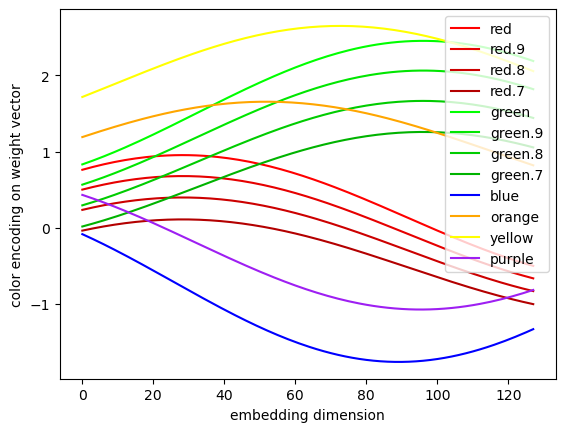

In [144]:


import matplotlib.pyplot as plt
import numpy as np

some_patches = [ Patch("red"   ,[1.0,0.0 ,0.0 ],0),
                Patch("orange",[1.0,0.65,0.0 ],1),
                Patch("yellow",[1.0,1.0 ,0.0 ],2),
                Patch("green" ,[0.0,1.0 ,0.0 ],3),
                Patch("blue"  ,[0.0,0.0 ,1.0 ],4),
                Patch("purple",[.62,0.12,0.95],5),
                Patch("black"   ,[0,0,0.]  ,6),
                Patch("grey"    ,[.7,.7,.7]  ,7),
                Patch("silver"  ,[1.0,1.0,1.0]  ,8),
                Patch("darkred" ,[.3,0.0 ,0.0 ]  ,9),
                ]

def visualize(patches) :
    y = [ represent_color(patch.color) for patch in patches ]
    fig, ax = plt.subplots()
    for y0,patch in zip(y,patches) :
        ax.plot(y0, color=patch.color, label=patch.text)
    ax.legend()
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

visualize(test_patches)

### view at the LAB colorspace

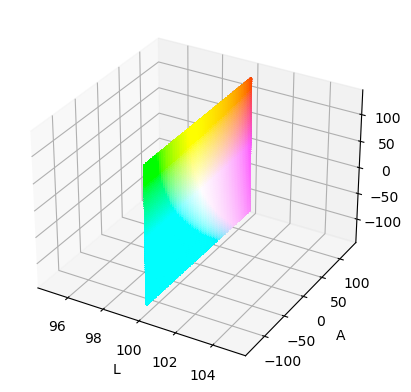

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import color

# Create a 3D grid of LAB values
# L = np.linspace(0, 100, 20)
A = np.linspace(-128, 127, 64)
B = np.linspace(-128, 127, 64)
L = np.ones_like(A) * 100

L, A, B = np.meshgrid(L, A, B, indexing='ij')
LAB = np.stack([L, A, B], axis=-1)

# Convert LAB to RGB
RGB = color.lab2rgb(LAB)

# Plot the LAB color space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(LAB[..., 0], LAB[..., 1], LAB[..., 2], c=RGB.reshape(-1, 3), s=1)
ax.set_xlabel('L')
ax.set_ylabel('A')
ax.set_zlabel('B')
plt.show()
